<a href="https://colab.research.google.com/github/YuliaLoburets/ML_learning/blob/main/HW_2_5_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
raw_df = pd.read_csv('drive/MyDrive/ML/Time Series/train.csv')
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df = raw_df.set_index('date')
raw_df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
raw_df['year'] = raw_df.index.year
raw_df['month'] = raw_df.index.month
raw_df['month_name'] = raw_df.index.strftime('%b')

In [6]:
raw_df.head()

,store,item,sales,year,month,month_name
date,,,,,,
2013-01-01,1,1,13,2013,1,Jan
2013-01-02,1,1,11,2013,1,Jan
2013-01-03,1,1,14,2013,1,Jan
2013-01-04,1,1,13,2013,1,Jan
2013-01-05,1,1,10,2013,1,Jan


<Axes: xlabel='date', ylabel='sales'>

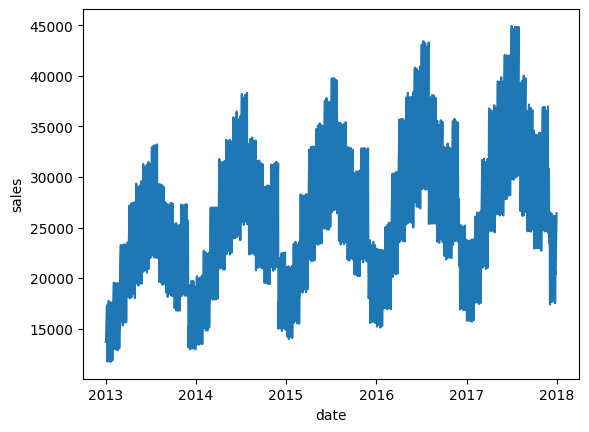

In [7]:
agg_sales = raw_df.groupby('date')['sales'].agg('sum').reset_index()
sns.lineplot(data=agg_sales, x='date', y='sales')

Згідно даного графіку видно, що є загальний тренд на збільшення продажів впродовж років. Також чітко спостерігається сезонність.

<Axes: xlabel='month', ylabel='year'>

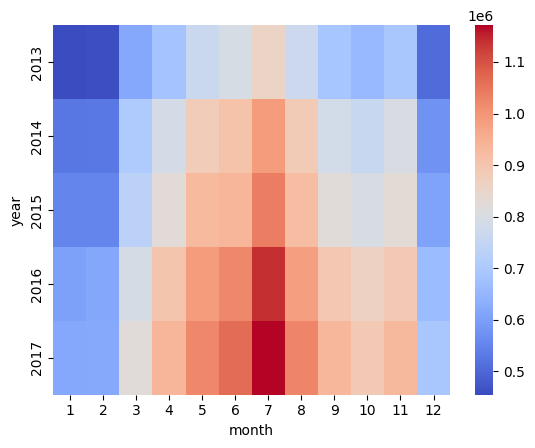

In [8]:
grouped_data = raw_df.groupby(['year','month'])['sales'].agg('sum').unstack()
sns.heatmap(grouped_data, cmap='coolwarm', annot=False)

Бачимо, що найбільші продажі спостерігаються саме у літній період, особливо в липні кожного року.

In [9]:
raw_subset = raw_df[['month_name','year','sales','store']].reset_index()

<Figure size 1000x500 with 0 Axes>

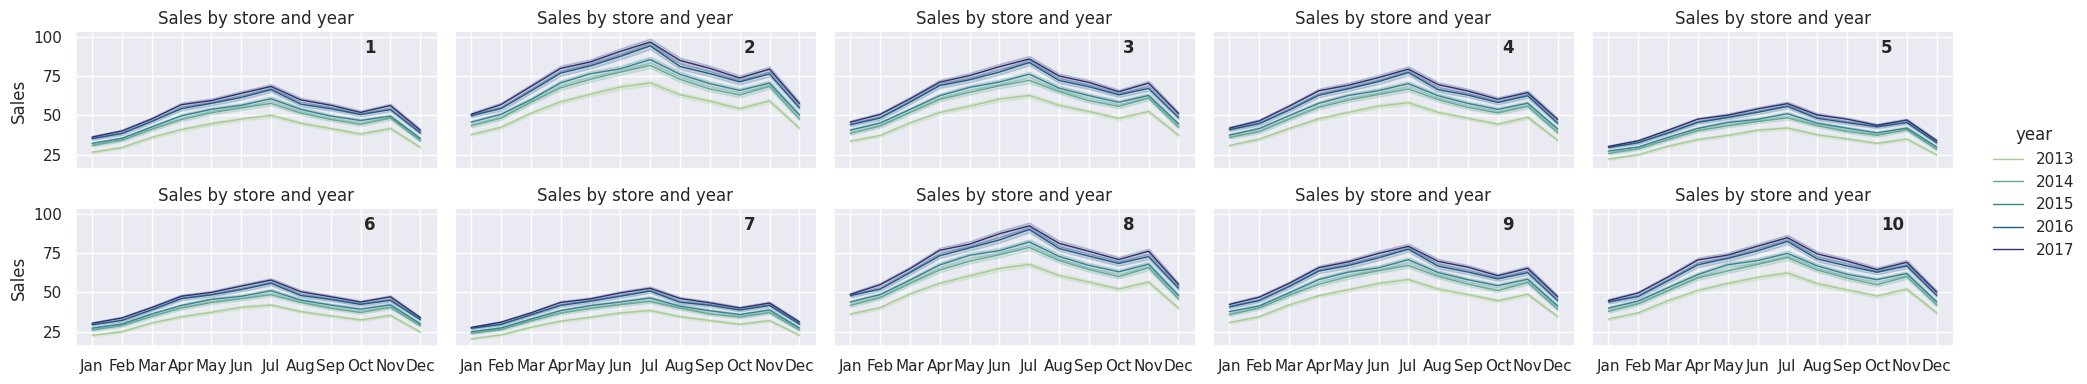

In [10]:
plt.figure(figsize=(10,5))
sns.set_theme(style='darkgrid')
g = sns.relplot(data=raw_subset, x='month_name', y='sales', hue='year', col='store',kind="line", palette="crest", linewidth=1, zorder=5, height=2,
    aspect=2, col_wrap=5, legend=True, errorbar=('ci', 95), estimator='mean')

for store, ax in g.axes_dict.items():
    ax.text(.8, .85, store, transform=ax.transAxes, fontweight="bold")


g.set_titles("Sales by store and year")
g.set_axis_labels("", "Sales")
g.tight_layout()

plt.show()


Згідно графіку можна сказати, що продажі для кожного з наявних магазинів збільшуються впродовж років. Найбільші продажі спостерігаються у магазинів 2,8,10. Найменші продажі в магазинах 1,5,6,7. Сезонність продажів спостерігається у кожного з магазинів - найбільші продажі літом, найнижчі - у зимовий період.

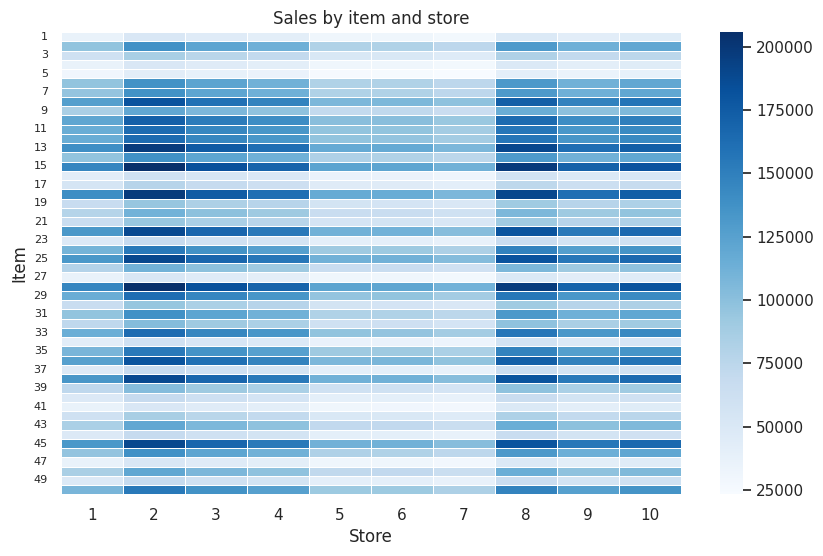

In [11]:
sales_pivot = raw_df.pivot_table(values='sales', index='item', columns='store', aggfunc='sum')
plt.figure(figsize=(10, 6))
sns.heatmap(sales_pivot, cmap="Blues", annot=False, fmt=".0f", linewidths=0.5)
plt.title("Sales by item and store")
plt.yticks(fontsize=8, rotation=0, ha='right')
plt.xlabel("Store")
plt.ylabel("Item")
plt.show()

Згідно графіку можна визначити, що найгірше по всіх магазинах продаються товари 1,4,5,16,17,23,27,34,40,41,42,44,47,49. Найгірші продажі усіх товарів у магазинів 1,5,6,7 у порівнянні з іншими магазинами, найкращі - у магазинів 2,8.

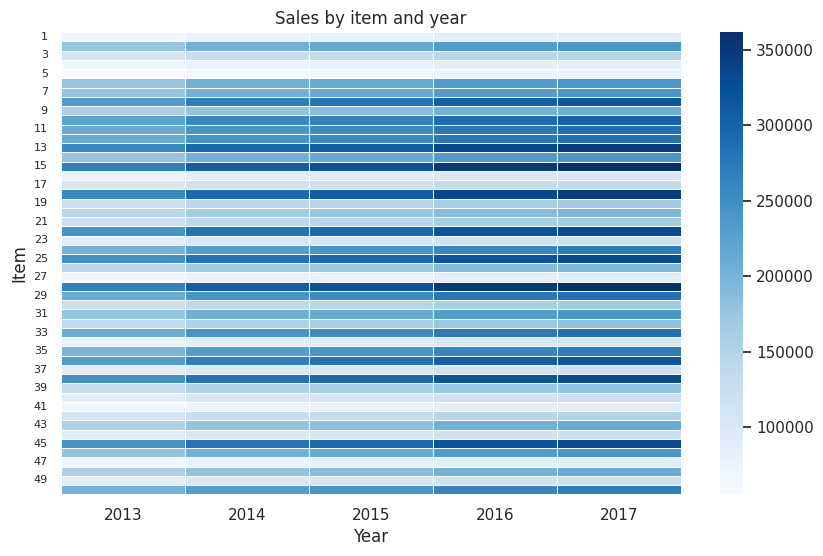

In [12]:
pivot = raw_df.pivot_table(values='sales', index='item', columns='year', aggfunc='sum')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Blues", annot=False, fmt=".0f", linewidths=0.5)
plt.title("Sales by item and year")
plt.yticks(fontsize=8, rotation=0, ha='right')
plt.xlabel("Year")
plt.ylabel("Item")
plt.show()

У більшості товарів позитивка динаміка - продажі збільшуються впродовж років. Найкраще продаються товари 15,18,25,28,45. Але є товари, динаміка продажу яких не змінюється з роками , такі як: 1,4,5,16,17,23,27,34,37,41,47,49 і забезпечують найнижчі продажі у порівнянні з іншими товарами.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [14]:
subset = raw_df[(raw_df['store']==1) & (raw_df['item']==1)]

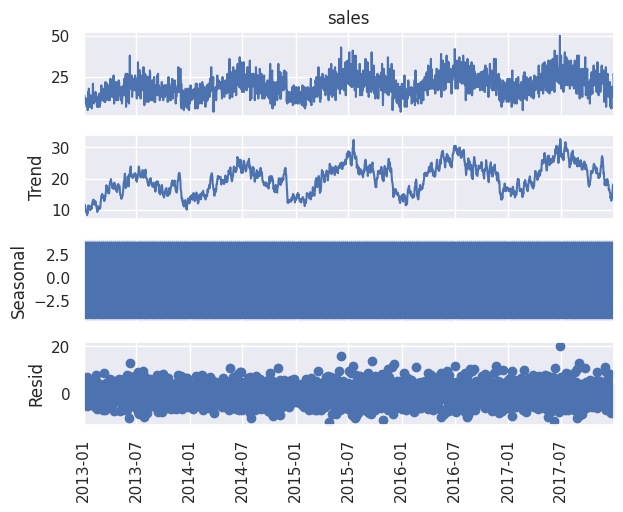

In [15]:
decomposition_plot_multi = seasonal_decompose(subset['sales'],
                                              model='additive')
decomposition_plot_multi.plot()
plt.xticks(rotation=90)
plt.show()

Неможливо зрозуміти паттерн сезонності, так як на графіках показуються продажі за кожний день. Зміню частоту інтервалу на місячну, щоб краще зрозуміти закономірності.

In [16]:
subset_fr = subset.asfreq('MS')

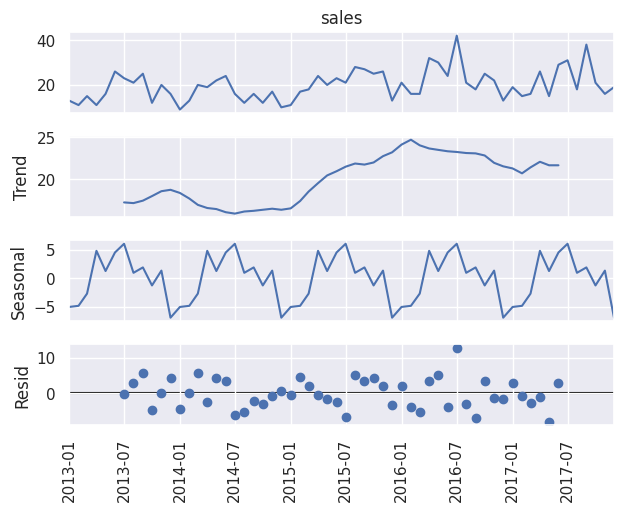

In [17]:
decomposition_plot_multi = seasonal_decompose(subset_fr['sales'],
                                              model='additive')
decomposition_plot_multi.plot()
plt.xticks(rotation=90)
plt.show()

1. Місячний тренд в цілому йде на збільшення з кожним роком , але починаючи з 2016 року йде на спад.
2. Сильно прослідковується сезонність - спостерігається збільшення продажів в літній період.
3. Паттерну в залишках не спостерігаю. В цілому залишки знаходяться близько до нуля.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [18]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.0/981.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00


In [19]:
from darts import TimeSeries

In [185]:
series = TimeSeries.from_dataframe(subset, value_cols='sales')
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) <U5 20B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='date'>

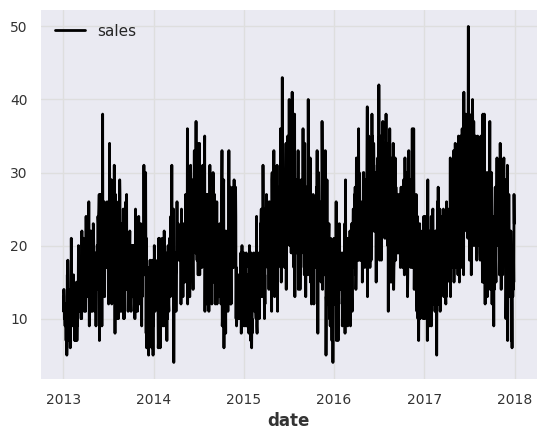

In [21]:
series.plot()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

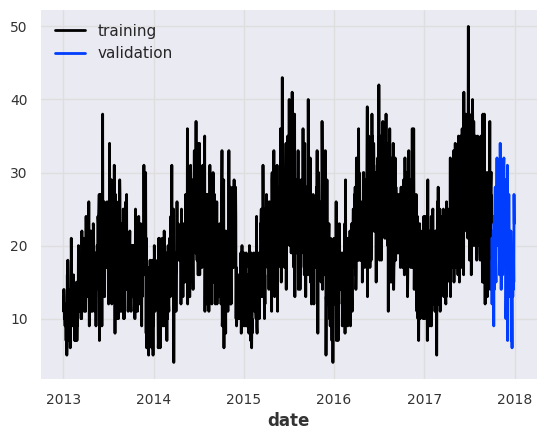

In [22]:
train, val = series.split_before(pd.Timestamp('2017-10-01'))
train.plot(label='training')
val.plot(label='validation')

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [23]:
from darts.utils.statistics import plot_acf, check_seasonality
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1000x1000 with 0 Axes>

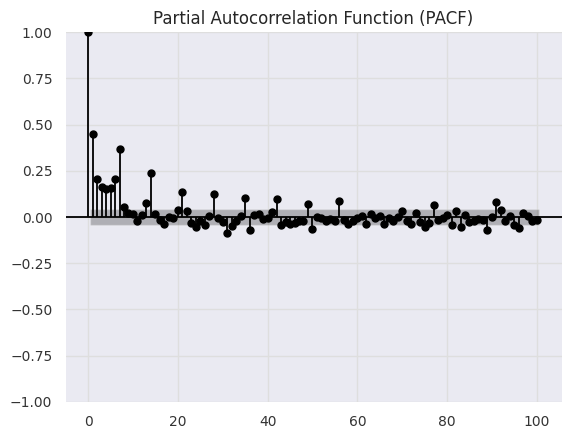

In [24]:
series_pd = series.pd_series()

plt.figure(figsize=(10, 10))
plot_pacf(series_pd, lags=100, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Згідно графіку найбільш статистично значими є лаги від 1 до 7, 14, 21 , 28. В цілому видно, що продажі за минулий тиждень мають сильну кореляцію на поточне значення продажів.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

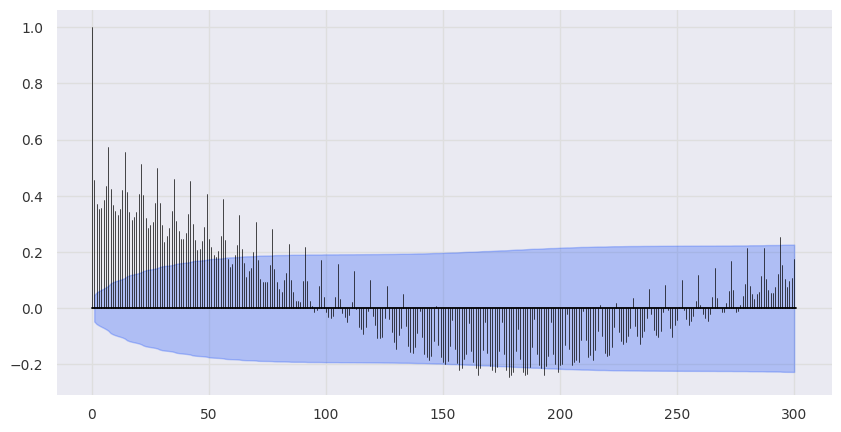

In [25]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, alpha=0.05, max_lag=300)

In [26]:
max_lag=300
for m in range(2, max_lag):
    is_seasonal, period = check_seasonality(train, m=m, max_lag=max_lag, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 74.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 224.
There is seasonality of order 231.
There is seasonality of order 238.
There is seasonality of order 245.
There is seasonality of order 252.
There is seasonality of order 259.
There is seasonality of order 266.
There is seasonality of order 273.
There is seasonality of order 280.
T

Згідно даного графіку та результатів функції видно чітку тижневу та річну сезонність.

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [27]:
subset[subset.index>='2017-10-01'].shape

(92, 6)

<Axes: xlabel='date'>

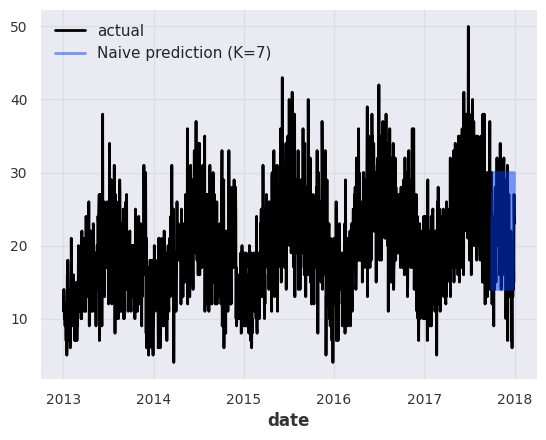

In [28]:
from darts.models import NaiveSeasonal
seasonal_model_weekly = NaiveSeasonal(K=7)
seasonal_model_weekly.fit(train)
seasonal_forecast_weekly = seasonal_model_weekly.predict(92)

series.plot(label="actual")
seasonal_forecast_weekly.plot(label="Naive prediction (K=7)", alpha=0.5)

При аргументі K=7 прогноз моделі дуже слабкий. Спробую виставити річну сезонність.

<Axes: xlabel='date'>

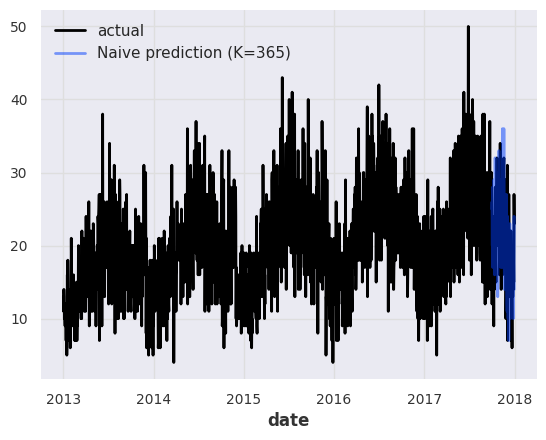

In [29]:
from darts.models import NaiveSeasonal
seasonal_model_year = NaiveSeasonal(K=365)
seasonal_model_year.fit(train)
seasonal_forecast_year = seasonal_model_year.predict(92)

series.plot(label="actual")
seasonal_forecast_year.plot(label="Naive prediction (K=365)",alpha=0.5)

При k=365 модель вже прогнозує значно краще

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [198]:
from darts.metrics import mape

def mape_calc(init_data, forecast, model):
  print(f"Mean absolute percentage error for {model} model: {mape(init_data,forecast):.2f}%.")

mape_calc(series,seasonal_forecast_year, 'Naive seasonal k=365')

Mean absolute percentage error for Naive seasonal k=365 model: 33.92%.


Помилка досить велика, що говорить про низьку точність прогнозу

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [146]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
import numpy as np

def enrich_with_date_features(df):
  df["hour"] = df['date'].dt.hour
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df['sin_year'] = np.sin(2 * np.pi * df["year"] / 365)
  df['cos_year'] = np.cos(2 * np.pi * df["year"] / 365)
  df["dayofmonth"] = df['date'].dt.day
  return df


train_transformed = TimeSeries.from_dataframe(
    enrich_with_date_features(train.pd_dataframe().reset_index()),
    time_col="date"
)

val_transformed = TimeSeries.from_dataframe(
    enrich_with_date_features(val.pd_dataframe().reset_index()),
    time_col="date"
)


# # Масштабування
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(val)


# Побудова моделі XGBoost
model = XGBModel(
    lags=365,  # Використання останніх спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_scaled)
pred = model.predict(91)
pred.values()[:, 0]

array([0.616859  , 0.30580947, 0.39890972, 0.43222982, 0.44043088,
       0.5000818 , 0.5527264 , 0.46285558, 0.32467982, 0.33196753,
       0.34009424, 0.44902503, 0.5361331 , 0.5477224 , 0.53429526,
       0.32665595, 0.38956803, 0.42645195, 0.45417935, 0.4662061 ,
       0.57826865, 0.49311954, 0.30192122, 0.35637236, 0.36285168,
       0.42682716, 0.5084979 , 0.53606355, 0.48343033, 0.31176278,
       0.36745378, 0.37904707, 0.42705622, 0.47060406, 0.53777945,
       0.4889696 , 0.27285957, 0.332874  , 0.4179442 , 0.3835505 ,
       0.48351258, 0.5464743 , 0.4922616 , 0.30364704, 0.36843285,
       0.3526807 , 0.36036566, 0.4517034 , 0.43991494, 0.4639721 ,
       0.27560097, 0.29481676, 0.31242847, 0.35097414, 0.41936177,
       0.4334924 , 0.49415663, 0.24471375, 0.30711287, 0.29514143,
       0.3242919 , 0.41384318, 0.38804603, 0.42374983, 0.20547158,
       0.26640955, 0.26449117, 0.31877166, 0.3985084 , 0.36429197,
       0.39010862, 0.22839412, 0.24482897, 0.30153432, 0.29929

In [147]:
scaler.inverse_transform(pred)

<TimeSeries (DataArray) (date: 91, component: 1, sample: 1)> Size: 364B
array([[[32.375515]],

       [[18.067236]],

       [[22.349848]],

       [[23.88257 ]],

       [[24.259819]],

       [[27.003761]],

       [[29.425413]],

       [[25.291355]],

       [[18.935272]],

       [[19.270508]],

...

       [[18.027323]],

       [[22.332592]],

       [[19.555372]],

       [[20.256659]],

       [[12.81518 ]],

       [[14.843085]],

       [[15.636796]],

       [[17.52867 ]],

       [[22.72992 ]],

       [[18.734606]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 728B 2017-10-01 2017-10-02 ... 2017-12-30
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

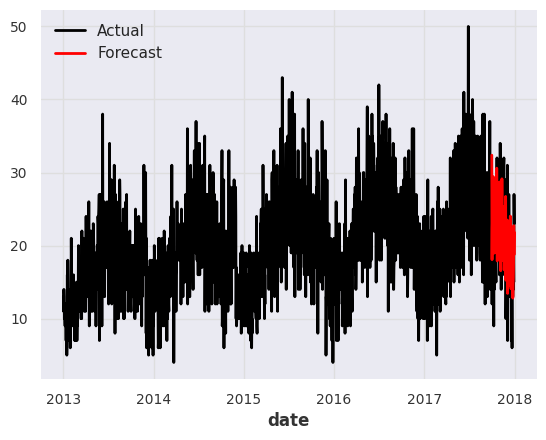

In [148]:
forecast = scaler.inverse_transform(model.predict(len(val)))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()


In [149]:
mape_calc(series,forecast, 'XGboost')

Mean absolute percentage error for XGboost model: 27.46%.


11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [56]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

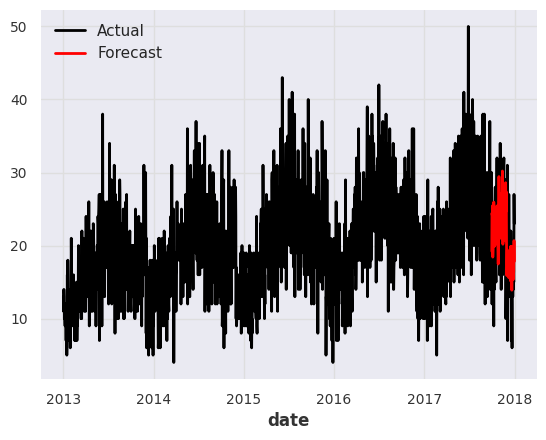

Mean absolute percentage error for ExponentialSmoothing model: 28.44%.


In [65]:
def plot_results(series, forecast):
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  mape_calc(series,forecast, 'ExponentialSmoothing')

model = ExponentialSmoothing(seasonal_periods=365)
fit_and_plot(model, series, train, val)

Модель бачить тренд, але не повністю бачить тижневі закономірності.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [186]:
from darts.models import ARIMA

model_arima = ARIMA(p=28, d=1, q=1)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


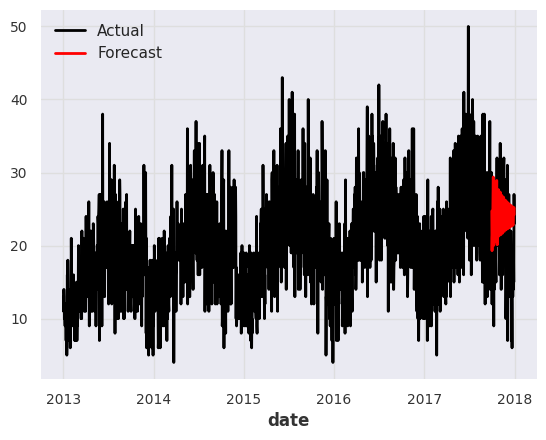

In [187]:
model_arima.fit(train)
forecast_arima = model_arima.predict(len(val))
plot_results(series=series, forecast=forecast_arima)

In [196]:
mape_error=mape(val,forecast_arima).values().mean()
print(f"MAPE: {mape_error:.2f}%")

MAPE: 37.05%


Дана модель показує погані результати та високу помилку

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

AutoARIMA(add_encoders=None, start_p=1, max_p=7, seasonal=True, m=7, max_P=2, max_Q=2, m_seasonal=365, stepwise=True)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['m_seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


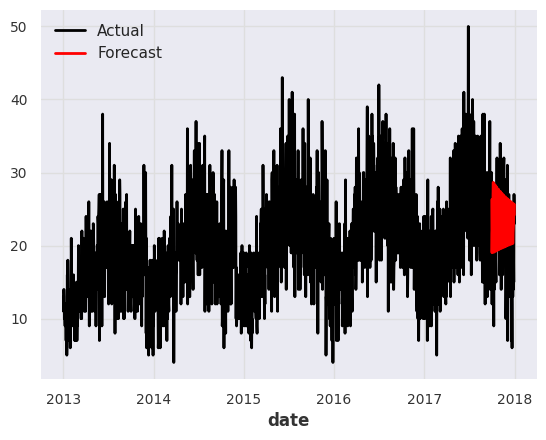

34.59986882597433

In [150]:
model = model = AutoARIMA(
    start_p=1, max_p=7,
    seasonal=True,
    m=7,
    max_P=2, max_Q=2,
    m_seasonal=365,
    stepwise=True
)
model.fit(train)
display(model)
forecast = model.predict(len(val))
plot_results(series, forecast)
mape(series, forecast, "AutoArima")

Результат, на жаль , не поліпшився

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv9velcn9/nht9xmx7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv9velcn9/0gz2wnfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50604', 'data', 'file=/tmp/tmpv9velcn9/nht9xmx7.json', 'init=/tmp/tmpv9velcn9/0gz2wnfr.json', 'output', 'file=/tmp/tmpv9velcn9/prophet_modelwdl_6ykl/prophet_model-20250316172750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


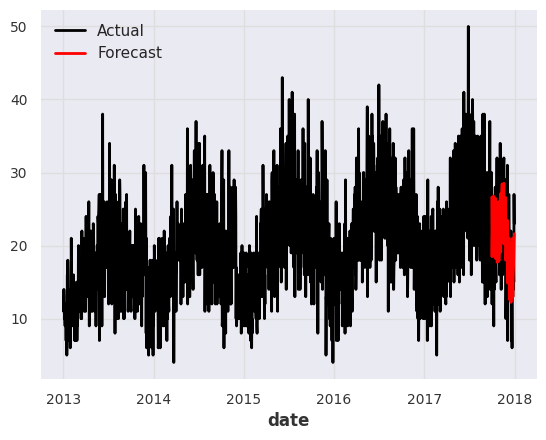

Mean absolute percentage error for Prophet model model: 23.80%.


In [77]:
from darts.models import Prophet

model = Prophet()
model.fit(train)

forecast_prophet = model.predict(len(val))

series.plot(label='Actual')
forecast_prophet.plot(label='Forecast', color='red')
plt.legend()
plt.show()
mape_calc(series, forecast_prophet, "Prophet model" )

Дана модель показала кращий результат порівняно з іншими моделями, але все рівно не вловлює всі закономірності, особливо тижневі.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

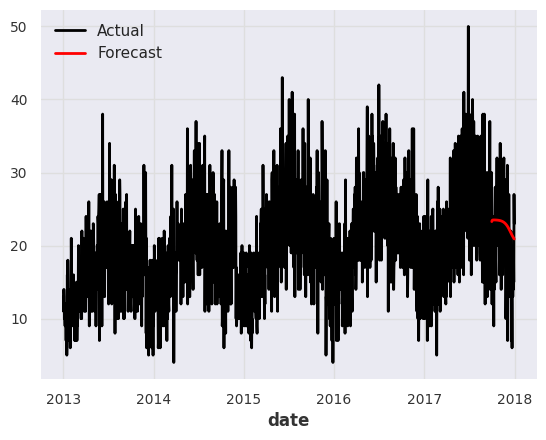

Mean absolute percentage error for Model RNN model: 33.70%.


In [86]:
from darts.models import RNNModel

# Побудова та тренування моделі LSTM
model = RNNModel(
    model="LSTM",
    input_chunk_length=300,
    training_length=365,
    n_epochs=100
)
model.fit(train)

# Прогнозування
forecast_rnn = model.predict(len(val))

# Візуалізація результатів
series.plot(label='Actual')
forecast_rnn.plot(label='Forecast', color='red')
plt.legend()
plt.show()
mape_calc(series, forecast_rnn, "Model RNN" )

Ця модель показала поганий результат

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

historical forecasts:   0%|          | 0/365 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv9velcn9/91l983r8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv9velcn9/ao_q12_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27437', 'data', 'file=/tmp/tmpv9velcn9/91l983r8.json', 'init=/tmp/tmpv9velcn9/ao_q12_o.json', 'output', 'file=/tmp/tmpv9velcn9/prophet_modelpv20tzhg/prophet_model-20250316202822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   0%|          | 1/365 [00:00<03:14,  1.87it/s]INFO:prophet

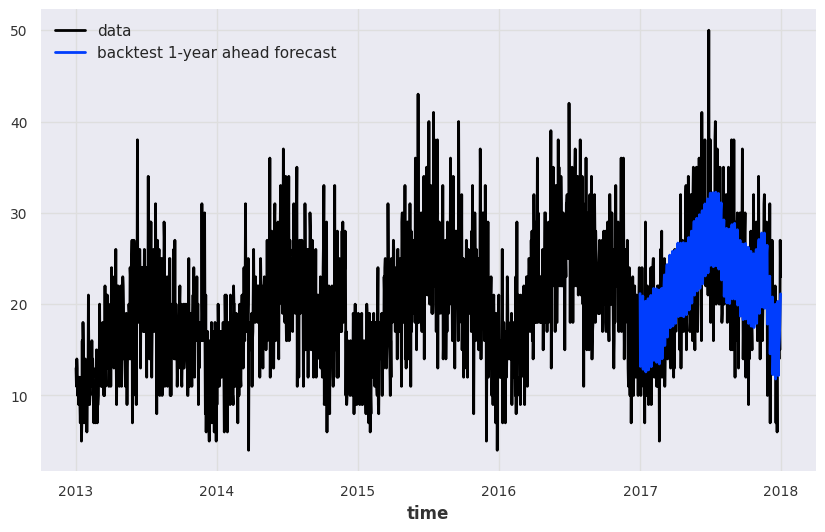

In [154]:
model_final = Prophet()

hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-01-01"),
    "forecast_horizon": 1,
    "verbose": True,
}

historical_fcast = model_final.historical_forecasts(last_points_only=True, **hfc_params)

plt.figure(figsize=(10, 6))
series.plot(label="data")
historical_fcast.plot(label="backtest 1-year ahead forecast")
plt.legend()
plt.show()



historical forecasts:   0%|          | 0/365 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv9velcn9/zeb2nqq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv9velcn9/mbkwfad5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78144', 'data', 'file=/tmp/tmpv9velcn9/zeb2nqq7.json', 'init=/tmp/tmpv9velcn9/mbkwfad5.json', 'output', 'file=/tmp/tmpv9velcn9/prophet_model226yl326/prophet_model-20250316205016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:50:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:50:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   0%|          | 1/365 [00:00<03:13,  1.88it/s]INFO:prophet

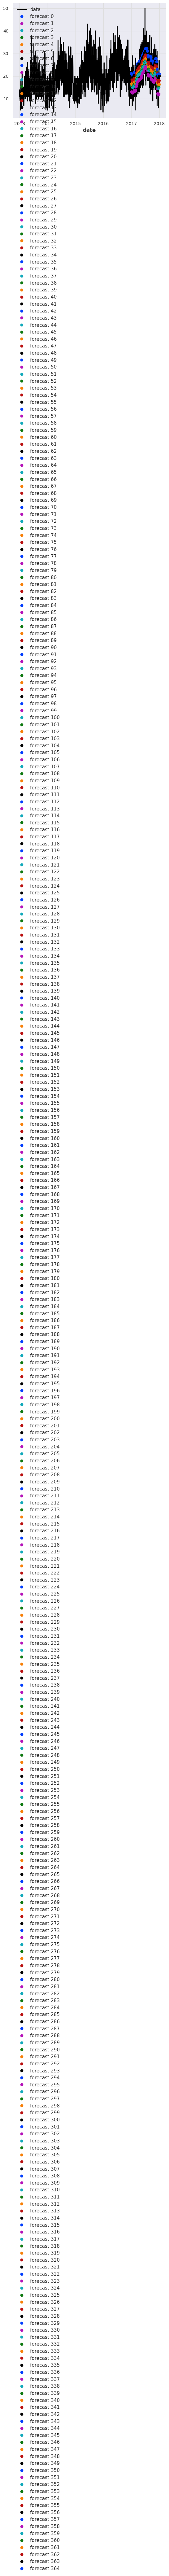

In [157]:
historical_fcast_all = model_final.historical_forecasts(last_points_only=False, stride=1, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0)

In [182]:
mape_value = mape(series, historical_fcast).values().mean()
print(f"MAPE: {mape_value:.2f}%")

MAPE: 20.89%


Модель показує достатньо високу помилку. Є ще необхідність покращити прогноз

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

1. Можна спробувати побудувати окрему модель для кожного виду товару відповідного магазину. Такий підхід дозволить більш точно вловити закономірності в історичних даних. Але звісно треба враховувати, що це буде досить ресурсно затратно.
2. Для того, щоб трохи зекономити ресурси та не будувати окрему модель для кожного товару, можна об'єднати деякі товари та магазини в категорії за схожими ознаками (наприклад об'єм продажів) і будувати моделі для кожного відповідного кластеру. Це дасть змогу зекономити час та обчислювальні ресурси.
3. Я би пробувала налаштувати модель Prophet, так як вона показала найменшу помилку у  порівнянні з іншими моделями , або модель XGBoost, яка включає в себе більш складні залежності.